In [1]:
import logging
import pathlib
import pprint
import sys

import joblib
import numpy as np
import pandas as pd
import toml
import torch

sys.path.append("../ML_utils/")

from parameter_set import parameter_set
from parameters import Parameters
from train_optimized_model import train_optimized_model

try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False
if in_notebook:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

In [2]:
model_name = "Cells_Intensity_MeanIntensityEdge_AnnexinV"
trained_model_path = pathlib.Path(
    "../trained_models/model_save_states/Regression/Cells_Intensity_MeanIntensityEdge_AnnexinV.pt"
).resolve(strict=True)
# read in the data
sc_file_path = pathlib.Path("../results/cleaned_sc_profile.parquet").resolve(
    strict=True
)
sc_endpoint_file_path = pathlib.Path(
    "../results/cleaned_endpoint_sc_profile.parquet"
).resolve(strict=True)

data_split_file_path = pathlib.Path("../results/data_splits.parquet").resolve(
    strict=True
)

sc_profile = pd.read_parquet(sc_file_path)
sc_endpoint_profile = pd.read_parquet(sc_endpoint_file_path)
data_split_df = pd.read_parquet(data_split_file_path)
print(f"sc_profile shape: {sc_profile.shape}")
print(f"sc_endpoint_profile shape: {sc_endpoint_profile.shape}")
print(f"data_split_df shape: {data_split_df.shape}")
data_split_df.head()

sc_profile shape: (182804, 2376)
sc_endpoint_profile shape: (11340, 368)
data_split_df shape: (14926, 3)


,index,data_split,data_x_or_y
0,7440,train_gt,X
1,7461,train_gt,X
2,7463,train_gt,X
3,7468,train_gt,X
4,7479,train_gt,X


In [3]:
# keep only the last timepoint
sc_profile["Metadata_Time"] = sc_profile["Metadata_Time"].astype("float64")
sc_profile = sc_profile[
    sc_profile["Metadata_Time"] == sc_profile["Metadata_Time"].max()
]
# drop Na values
sc_profile.dropna(inplace=True)
print(f"sc_profile shape after dropping NaN: {sc_profile.shape}")
sc_endpoint_profile.dropna(inplace=True)
print(f"sc_endpoint_profile shape after dropping NaN: {sc_endpoint_profile.shape}")
# hardcode the features that should exist in the y data
# this will be replaced in the future by an arg or config passed through
selected_y_features = ["Cells_Intensity_MeanIntensityEdge_AnnexinV"]
metadata_y_features = [x for x in sc_endpoint_profile.columns if "Metadata_" in x]
sc_endpoint_profile = sc_endpoint_profile[metadata_y_features + selected_y_features]
print(
    f"sc_endpoint_profile shape after selecting features: {sc_endpoint_profile.shape}"
)

sc_profile shape after dropping NaN: (14237, 2376)
sc_endpoint_profile shape after dropping NaN: (11136, 368)
sc_endpoint_profile shape after selecting features: (11136, 26)


In [4]:
profile_data_splits_df = data_split_df.loc[data_split_df["data_x_or_y"] == "X"]
profile_data_splits_df
endpoint_data_splits_df = data_split_df.loc[data_split_df["data_x_or_y"] == "y"]
endpoint_data_splits_df
# replace the index with the index column
profile_data_splits_df = profile_data_splits_df.set_index(
    "index", drop=True, verify_integrity=True
)
endpoint_data_splits_df = endpoint_data_splits_df.set_index(
    "index", drop=True, verify_integrity=True
)
# remove the index name from profile_data_splits_df
profile_data_splits_df.index.name = None
# remove the index name from endpoint_data_splits_df
endpoint_data_splits_df.index.name = None

In [5]:
# get only indexes from sc_profile that are in the train_gt split
train_gt_X = sc_profile.loc[
    sc_profile.index.isin(
        profile_data_splits_df.loc[
            profile_data_splits_df["data_split"] == "train_gt"
        ].index
    )
]
val_gt_X = sc_profile.loc[
    sc_profile.index.isin(
        profile_data_splits_df.loc[
            profile_data_splits_df["data_split"] == "val_gt"
        ].index
    )
]
train_gt_y = sc_endpoint_profile.loc[
    sc_endpoint_profile.index.isin(
        endpoint_data_splits_df.loc[
            endpoint_data_splits_df["data_split"] == "train_gt"
        ].index
    )
]
val_gt_y = sc_endpoint_profile.loc[
    sc_endpoint_profile.index.isin(
        endpoint_data_splits_df.loc[
            endpoint_data_splits_df["data_split"] == "val_gt"
        ].index
    )
]
test_gt_X = sc_profile.loc[
    sc_profile.index.isin(
        profile_data_splits_df.loc[
            profile_data_splits_df["data_split"] == "test_gt"
        ].index
    )
]
test_gt_y = sc_endpoint_profile.loc[
    sc_endpoint_profile.index.isin(
        endpoint_data_splits_df.loc[
            endpoint_data_splits_df["data_split"] == "test_gt"
        ].index
    )
]
holdout_gt_X = sc_profile.loc[
    sc_profile.index.isin(
        profile_data_splits_df.loc[
            profile_data_splits_df["data_split"] == "holdout_gt"
        ].index
    )
]
holdout_gt_y = sc_endpoint_profile.loc[
    sc_endpoint_profile.index.isin(
        endpoint_data_splits_df.loc[
            endpoint_data_splits_df["data_split"] == "holdout_gt"
        ].index
    )
]


test_no_gt_X = sc_profile.loc[
    sc_profile.index.isin(
        profile_data_splits_df.loc[
            profile_data_splits_df["data_split"] == "test_wo_gt"
        ].index
    )
]

holdout_no_gt_X = sc_profile.loc[
    sc_profile.index.isin(
        profile_data_splits_df.loc[
            profile_data_splits_df["data_split"] == "holdout_wo_gt"
        ].index
    )
]


# assertion checks
assert train_gt_X.shape[0] == train_gt_y.shape[0]
assert val_gt_X.shape[0] == val_gt_y.shape[0]
assert train_gt_X.shape[1] == val_gt_X.shape[1]
assert train_gt_y.shape[1] == val_gt_y.shape[1]
assert test_gt_X.shape[0] == test_gt_y.shape[0]
assert holdout_gt_X.shape[0] == holdout_gt_y.shape[0]


assert train_gt_X.shape[0] > 0
assert val_gt_X.shape[0] > 0
assert train_gt_y.shape[0] > 0
assert val_gt_y.shape[0] > 0
assert test_gt_X.shape[0] > 0
assert test_gt_y.shape[0] > 0
assert holdout_gt_X.shape[0] > 0
assert holdout_gt_y.shape[0] > 0
assert test_no_gt_X.shape[0] > 0
assert holdout_no_gt_X.shape[0] > 0

In [6]:
# get metadata
metadata_X_cols = [x for x in train_gt_X.columns if "Metadata_" in x]
metadata_y_cols = [x for x in train_gt_y.columns if "Metadata_" in x]


train_gt_X_metadata = train_gt_X[metadata_X_cols]
train_gt_X.drop(columns=metadata_X_cols, inplace=True)
train_gt_y_metadata = train_gt_y[metadata_y_cols]
train_gt_y.drop(columns=metadata_y_cols, inplace=True)
val_gt_X_metadata = val_gt_X[metadata_X_cols]
val_gt_X.drop(columns=metadata_X_cols, inplace=True)
val_gt_y_metadata = val_gt_y[metadata_y_cols]
val_gt_y.drop(columns=metadata_y_cols, inplace=True)
test_gt_X_metadata = test_gt_X[metadata_X_cols]
test_gt_X.drop(columns=metadata_X_cols, inplace=True)
test_gt_y_metadata = test_gt_y[metadata_y_cols]
test_gt_y.drop(columns=metadata_y_cols, inplace=True)
holdout_gt_X_metadata = holdout_gt_X[metadata_X_cols]
holdout_gt_X.drop(columns=metadata_X_cols, inplace=True)
holdout_gt_y_metadata = holdout_gt_y[metadata_y_cols]
holdout_gt_y.drop(columns=metadata_y_cols, inplace=True)


test_not_gt_X_metadata = test_no_gt_X[metadata_X_cols]
test_no_gt_X.drop(columns=metadata_X_cols, inplace=True)
holdout_no_gt_X_metadata = holdout_no_gt_X[metadata_X_cols]
holdout_no_gt_X.drop(columns=metadata_X_cols, inplace=True)

/tmp/ipykernel_1278339/2951086784.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_gt_X.drop(columns=metadata_X_cols, inplace=True)
/tmp/ipykernel_1278339/2951086784.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_gt_y.drop(columns=metadata_y_cols, inplace=True)
/tmp/ipykernel_1278339/2951086784.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_gt_X.drop(columns=metadata_X_cols, inplace=True)
/tmp/ipykernel_12

In [7]:
# shuffle the data
shuffled_train_gt_X = train_gt_X.copy()
for col in shuffled_train_gt_X.columns:
    if col.startswith("Metadata_"):
        continue
    shuffled_train_gt_X[col] = np.random.permutation(shuffled_train_gt_X[col].values)
shuffled_val_gt_X = val_gt_X.copy()
for col in shuffled_val_gt_X.columns:
    if col.startswith("Metadata_"):
        continue
    shuffled_val_gt_X[col] = np.random.permutation(shuffled_val_gt_X[col].values)
shuffled_test_gt_X = test_gt_X.copy()
for col in shuffled_test_gt_X.columns:
    if col.startswith("Metadata_"):
        continue
    shuffled_test_gt_X[col] = np.random.permutation(shuffled_test_gt_X[col].values)
shuffled_holdout_gt_X = holdout_gt_X.copy()
for col in shuffled_holdout_gt_X.columns:
    if col.startswith("Metadata_"):
        continue
    shuffled_holdout_gt_X[col] = np.random.permutation(
        shuffled_holdout_gt_X[col].values
    )
shuffled_test_no_gt_X = test_no_gt_X.copy()
for col in shuffled_test_no_gt_X.columns:
    if col.startswith("Metadata_"):
        continue
    shuffled_test_no_gt_X[col] = np.random.permutation(
        shuffled_test_no_gt_X[col].values
    )
shuffled_holdout_no_gt_X = holdout_no_gt_X.copy()
for col in shuffled_holdout_no_gt_X.columns:
    if col.startswith("Metadata_"):
        continue
    shuffled_holdout_no_gt_X[col] = np.random.permutation(
        shuffled_holdout_no_gt_X[col].values
    )

In [8]:
# number of input features
n_features = train_gt_X.shape[1]
# number of output features
n_outputs = train_gt_y.shape[1]
# number of metadata features
n_metadata_features = train_gt_X_metadata.shape[1]

print(f"n_features: {n_features}")
print(f"n_outputs: {n_outputs}")
print(f"n_metadata_features: {n_metadata_features}")

n_features: 2338
n_outputs: 1
n_metadata_features: 38


In [9]:
params = Parameters()
ml_configs = toml.load("../ML_utils/regression_class_config.toml")
mlp_params = parameter_set(params, ml_configs)
mlp_params.IN_FEATURES = n_features
mlp_params.OUT_FEATURES = n_outputs

In [10]:
print(train_gt_X.shape, train_gt_y.shape)
print(val_gt_X.shape, val_gt_y.shape)
print(test_gt_X.shape, test_gt_y.shape)
print(holdout_gt_X.shape, holdout_gt_y.shape)
print(test_no_gt_X.shape)
print(holdout_no_gt_X.shape)

(367, 2338) (367, 1)
(49, 2338) (49, 1)
(49, 2338) (49, 1)
(237, 2338) (237, 1)
(9137, 2338)
(4385, 2338)


In [11]:
X_train = torch.tensor(train_gt_X.values, dtype=torch.float32)
y_train = torch.tensor(train_gt_y.values, dtype=torch.float32)
X_val = torch.tensor(val_gt_X.values, dtype=torch.float32)
y_val = torch.tensor(val_gt_y.values, dtype=torch.float32)
X_test = torch.tensor(test_gt_X.values, dtype=torch.float32)
y_test = torch.tensor(test_gt_y.values, dtype=torch.float32)
X_holdout = torch.tensor(holdout_gt_X.values, dtype=torch.float32)
y_holdout = torch.tensor(holdout_gt_y.values, dtype=torch.float32)

X_test_no_gt = torch.tensor(test_no_gt_X.values, dtype=torch.float32)
X_holdout_no_gt = torch.tensor(holdout_no_gt_X.values, dtype=torch.float32)

In [12]:
# get the dtypes of the data
print(f"X_train dtypes: {X_train.dtype}")
print(f"y_train dtypes: {y_train.dtype}")
print(f"X_val dtypes: {X_val.dtype}")
print(f"y_val dtypes: {y_val.dtype}")
print(f"X_test dtypes: {X_test.dtype}")
print(f"y_test dtypes: {y_test.dtype}")
print(f"X_holdout dtypes: {X_holdout.dtype}")
print(f"y_holdout dtypes: {y_holdout.dtype}")
print(f"X_test_no_gt dtypes: {X_test_no_gt.dtype}")
print(f"X_holdout_no_gt dtypes: {X_holdout_no_gt.dtype}")

X_train dtypes: torch.float32
y_train dtypes: torch.float32
X_val dtypes: torch.float32
y_val dtypes: torch.float32
X_test dtypes: torch.float32
y_test dtypes: torch.float32
X_holdout dtypes: torch.float32
y_holdout dtypes: torch.float32
X_test_no_gt dtypes: torch.float32
X_holdout_no_gt dtypes: torch.float32


In [13]:
# produce data objects for train, val and test datasets
train_data = torch.utils.data.TensorDataset(X_train, y_train)
val_data = torch.utils.data.TensorDataset(X_val, y_val)


# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=mlp_params.HYPERPARAMETER_BATCH_SIZE, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.HYPERPARAMETER_BATCH_SIZE, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.HYPERPARAMETER_BATCH_SIZE, shuffle=False
)
holdout_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.HYPERPARAMETER_BATCH_SIZE, shuffle=False
)
test_no_gt_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.HYPERPARAMETER_BATCH_SIZE, shuffle=False
)
holdout_no_gt_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.HYPERPARAMETER_BATCH_SIZE, shuffle=False
)

In [18]:
from create_optimized_model import optimized_model_create

model, parameter_dict = optimized_model_create(params, model_name)

In [19]:
from test_optimized_model import test_optimized_model

In [57]:
y_pred_list, Y_test_list = test_optimized_model(
    model,
    train_loader,
    mlp_params,
    model_name="Cells_Intensity_MeanIntensityEdge_AnnexinV",
    shuffle=False,
)

Cells_Intensity_MeanIntensityEdge_AnnexinV


In [58]:
# calculate the mean squared error for the predictions
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mean_absolute_errors = []
mean_squared_errors = []
r2_scores = []
for i in range(len(y_pred_list)):
    y_pred = y_pred_list[i]
    y_test = Y_test_list[i]
    mean_absolute_errors.append(mean_absolute_error(y_test, y_pred))
    mean_squared_errors.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
print(f"Mean Absolute Errors: {mean_absolute_errors}")
print(f"Mean Squared Errors: {mean_squared_errors}")
print(f"R2 Scores: {r2_scores}")

Mean Absolute Errors: [0.7142975330352783]
Mean Squared Errors: [1.0875264406204224]
R2 Scores: [-0.0001246929168701172]


In [81]:
import itertools

In [95]:
def nested_array_to_list(nested_array):
    """
    A recursive function to fully flatten and convert a nested array or list to a Python list.
    """
    if isinstance(nested_array, (np.ndarray, list)):
        # Recursively flatten each element
        return [
            nested_array_to_list(item)
            for sublist in nested_array
            for item in (
                list(itertools.chain.from_iterable(sublist))
                if isinstance(sublist, (list, np.ndarray))
                else [sublist]
            )
        ]
    else:
        return nested_array

In [97]:
# flatten the list of lists via itertools
y_pred_flat = list(itertools.chain.from_iterable(y_pred_list))
y_test_flat = nested_array_to_list(Y_test_list)

In [98]:
print(f"y_pred_flat shape: {len(y_pred_flat)}")
print(f"y_test_flat shape: {len(y_test_flat)}")

y_pred_flat shape: 367
y_test_flat shape: 367


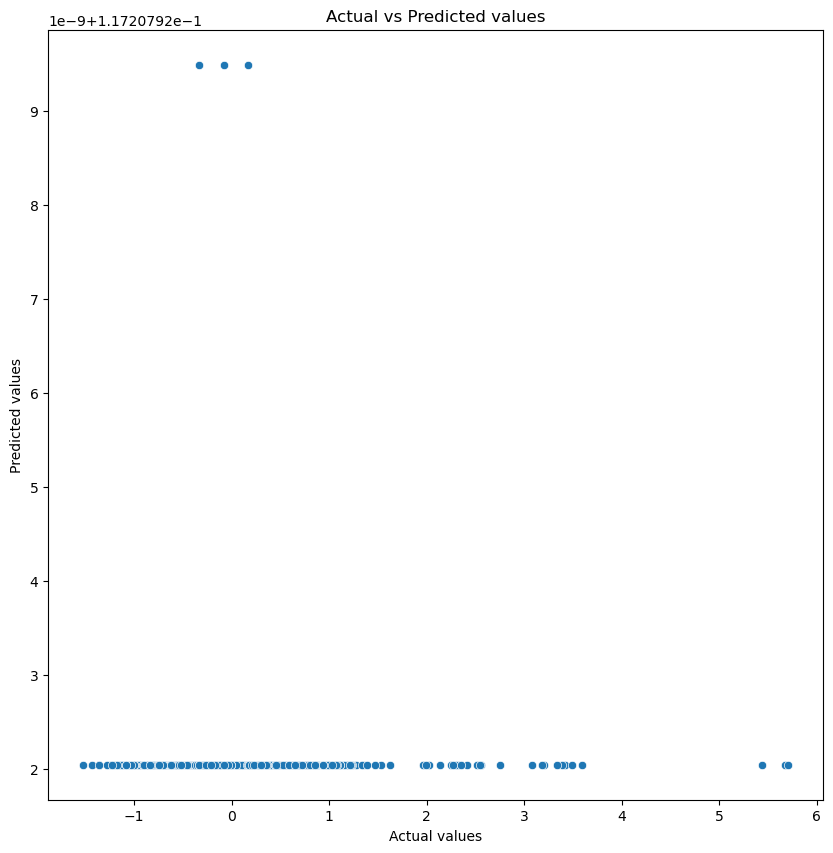

In [103]:
# plot the actual vs predicted values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.title("Actual vs Predicted values")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
sns.scatterplot(x=y_test_flat, y=y_pred_flat)
# plt.xlim(y_pred_flat.min(), y_test_flat.max())
# plt.ylim(y_pred_flat.min(), y_test_flat.max())
plt.show()